In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
train_df = pd.read_csv('train_1Dx.csv',nrows=1000000)
test_df = pd.read_csv('test_1Dx.csv',nrows=50000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
model = Sequential()
model.add(Dense(64, input_shape=(21,), activation='relu')) # Add an input shape! (features,)
model.add(Dense(2, activation='linear'))
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1408      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,538
Trainable params: 1,538
Non-trainable params: 0
_________________________________________________________________


2022-11-01 17:11:29.255718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:11:29.292649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:11:29.292997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:11:29.293754: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [6]:
def custom_loss(y, p):
    
    maxval = 1e6
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = tf.clip_by_value(tf.gather(params=p, indices=[1], axis=1),minval,maxval)
        
    term = tf.clip_by_value(1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma)),minval,maxval)
    NLL = tf.clip_by_value(-1*tf.math.log(term),minval,maxval)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
model.compile(optimizer='Adam', 
              loss=custom_loss)

In [8]:
es = EarlyStopping(patience=5)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/80
  104/12500 [..............................] - ETA: 18s - loss: 19.2852  

2022-11-01 17:11:31.520110: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12500/12500 [==============================] - 23s 2ms/step - loss: 4.1258 - val_loss: 3.4166
Epoch 2/80
12500/12500 [==============================] - 22s 2ms/step - loss: 3.3581 - val_loss: 3.3235
Epoch 3/80
12500/12500 [==============================] - 22s 2ms/step - loss: 3.3000 - val_loss: 3.2824
Epoch 4/80
12500/12500 [==============================] - 22s 2ms/step - loss: 3.2702 - val_loss: 3.2611
Epoch 5/80
12500/12500 [==============================] - 21s 2ms/step - loss: 3.2516 - val_loss: 3.2446
Epoch 6/80
12500/12500 [==============================] - 21s 2ms/step - loss: 3.2379 - val_loss: 3.2298
Epoch 7/80
12500/12500 [==============================] - 21s 2ms/step - loss: 3.2267 - val_loss: 3.2200
Epoch 8/80
12500/12500 [==============================] - 21s 2ms/step - loss: 3.2157 - val_loss: 3.2084
Epoch 9/80
12500/12500 [==============================] - 22s 2ms/step - loss: 3.2066 - val_loss: 3.2005
Epoch 10/80
12500/12500 [==============================] - 22s 2ms

/tmp/ipykernel_39778/3321773974.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


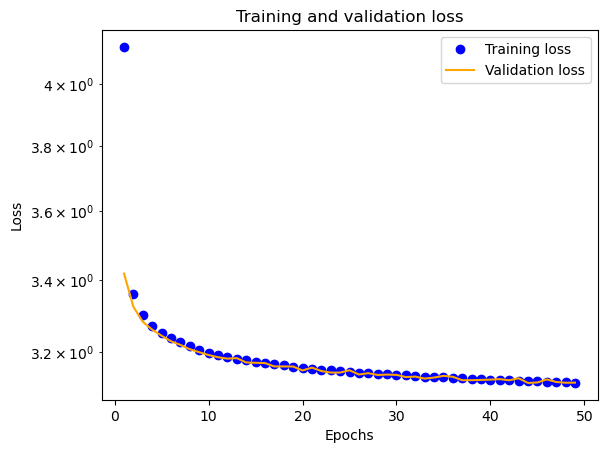

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
plt.show()

In [10]:
model.save('models_1Dx/gauss.keras')

In [11]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['xtrue'] = y_test
df.to_csv("test_1DxGauss.csv",header=False,index=False)

In [12]:
residuals = y_test - p_test[:,0]
print(np.mean(residuals),np.std(residuals))

-0.5153014494957217 6.558438230781734


In [13]:
uncertainty= p_test[:,1]
print(np.mean(uncertainty),np.std(uncertainty))

5.8089867 2.3961535


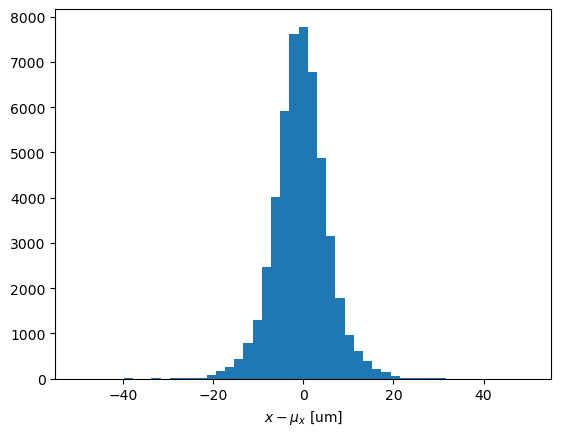

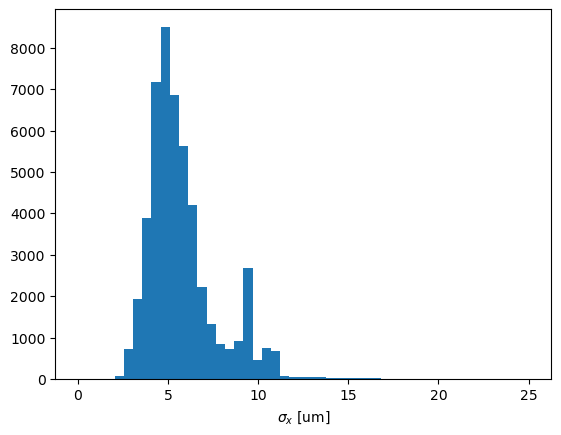

In [14]:
plt.hist(residuals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.show()

plt.hist(uncertainty,bins=np.linspace(0,25,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

Text(0, 0.5, 'Predicted $x$ [um]')

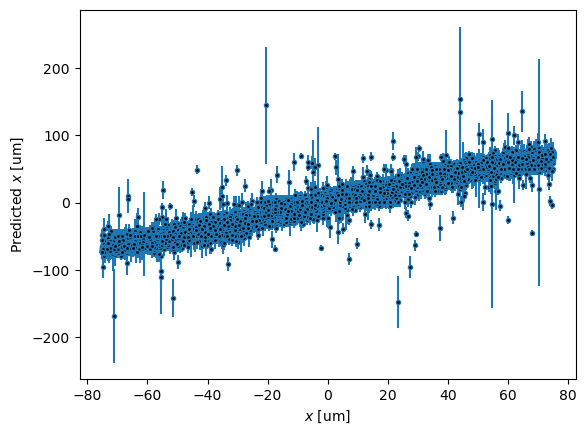

In [15]:
plt.errorbar(x=y_test,y=p_test[:,0],yerr=p_test[:,1],linestyle='',marker='.',markerfacecolor='black')
plt.xlabel(r'$x$ [um]')
plt.ylabel(r'Predicted $x$ [um]')

Text(0, 0.5, '$\\sigma_x$ [um]')

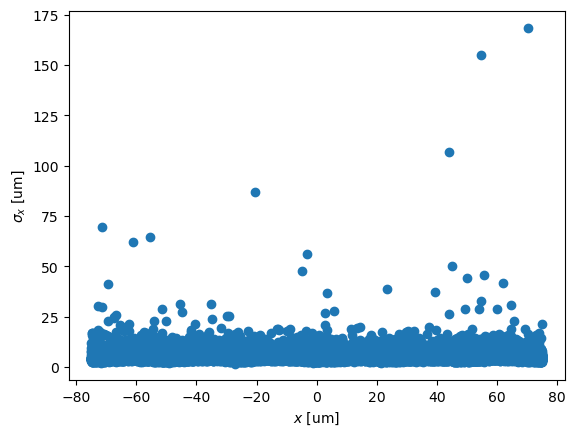

In [16]:
plt.scatter(y_test,p_test[:,1])
plt.xlabel(r'$x$ [um]')
plt.ylabel(r'$\sigma_x$ [um]')

In [17]:
pulls = residuals/p_test[:,1]

Text(0.5, 0, 'pull')

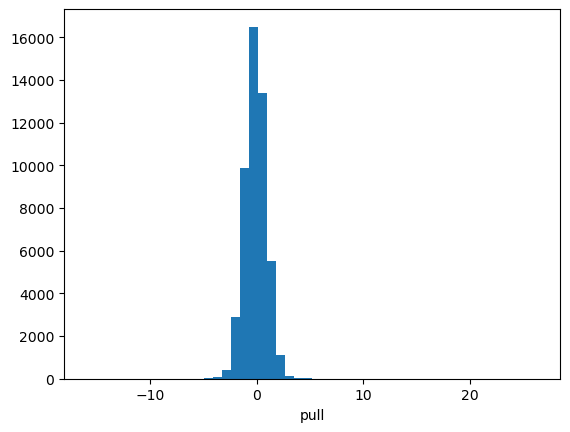

In [18]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [19]:
print(np.mean(pulls),np.std(pulls))

-0.09920159610021448 1.0308109018482103
